# ECG-based PUF

### 3.2 Data Pre Processing
Load the entire dataset and assign to variable ```dict_all_records```.

In [1]:
import numpy as np
import wfdb
db_name = "ecgiddb/"
dict_all_records = dict()
f = open(db_name + "RECORDS", "r")
for y in f.readlines():
    person = y.split("/")[0].strip()
    record = y.split("/")[1].strip()
    # The record cannot be duplicate, so we can safely insert it everytime, w/o checking
    if person not in dict_all_records:
        dict_all_records[person] = {record: wfdb.rdrecord(db_name + person + "/" + record, sampfrom=0, channels=[1])}
    else:
        dict_all_records[person].update({record: wfdb.rdrecord(db_name + person + "/" + record, sampfrom=0, channels=[1])})

Detect QRS Complex on each signal in order to apply splitting and then proceed with filtering

In [2]:
from wfdb import processing
dict_all_peaks = dict()
for person in dict_all_records:
    dict_all_peaks[person] = dict()
    for record in dict_all_records[person]:
        signal_detected = dict_all_records[person][record]
        qrs_inds = processing.qrs.gqrs_detect(sig=signal_detected.p_signal[:,0], fs=signal_detected.fs)
        if len(qrs_inds) < 1:
            continue
        # Correct the peaks shifting them to local maxima
        min_bpm = 20
        max_bpm = 230
        # min_gap = record.fs * 60 / min_bpm
        # Use the maximum possible bpm as the search radius
        search_radius = int(signal_detected.fs * 60 / max_bpm)
        corrected_peak_inds = processing.peaks.correct_peaks(signal_detected.p_signal[:,0], peak_inds=qrs_inds, search_radius=search_radius, smooth_window_size=150)
        dict_all_peaks[person][record] = sorted(corrected_peak_inds)

In [19]:
from sympy import fwht
import pandas as pd
import struct
import math
results_full = dict()
results_single = dict()
for windows_size in [150, 180, 200, 250]:
    results_full[windows_size] = dict()
    results_single[windows_size] = dict()
    splitted_signal = dict()
    for person in dict_all_peaks:
        splitted_signal[person] = dict()
        for corrected_peak_inds in dict_all_peaks[person]:
            splitted_signal[person][corrected_peak_inds] = list()
            for r in dict_all_peaks[person][corrected_peak_inds]:
                if r<(windows_size + 1) or r>(10000 - windows_size - 1):
                    continue
                # Get from the original signal, at this point we can apply the noise removal algorithm
                current_seq = dict_all_records[person][corrected_peak_inds].p_signal[r-windows_size:r+windows_size].tolist()
                splitted_signal[person][corrected_peak_inds].append(current_seq)
    filtered_dataset = dict()
    for person in splitted_signal:
        filtered_dataset[person] = dict()
        for record in splitted_signal[person]:
            filtered_dataset[person][record] = list()

            test = splitted_signal[person][record]
            # Parsing to a list with single values
            for y in test:
                current_sign = list()
                for z in y:
                    current_sign.append(float(z[0]))
                filtered_dataset[person][record].append(current_sign)
    transformed_dataset = dict()
    for person in filtered_dataset:
        transformed_dataset[person] = dict()
        for record in filtered_dataset[person]:
            sequences = np.average(filtered_dataset[person][record], axis=0)
            transformed_dataset[person][record] = fwht(sequences.ravel().tolist())

    dict_binaries = dict()
    for person in transformed_dataset:
        dict_binaries[person] = dict()
        for record in transformed_dataset[person]:
            final_string = list()
            dict_binaries[person][record] = list()
            for x in transformed_dataset[person][record]:
                final_string.append(''.join('{:0>8b}'.format(c) for c in struct.pack('!f', float(x))))
            final_string = ''.join(final_string)
            # Insert binary representation as single bit in an array
            for y in final_string:
                dict_binaries[person][record].append(y)
    # Let's compute the fractional Hamming Distance for each pair, only for intra distance
    all_fhd_dataset = pd.DataFrame(columns=["p", "r1", "r2", "dist"])
    complex_sum = 0
    for person in dict_binaries:
        list_of_records = list(dict_binaries[person].values())
        for index1 in range(0, len(list_of_records) - 1):
            for index2 in range(index1 + 1, len(list_of_records)):
                first = np.array(list_of_records[index1], dtype=np.float64)
                second = np.array(list_of_records[index2], dtype=np.float64)
                fhd_ij = np.sum(np.abs(first - second))/len(first) # or second len, it is the same
                all_fhd_dataset.loc[len(all_fhd_dataset)] = [person, index1, index2, fhd_ij]
    all_persons = list(dict_binaries.keys())
    size_all_persons = len(all_persons)
    all_fhd_dataset_full = pd.DataFrame(columns=["p1", "p2", "r1", "r2", "dist"])
    for index1 in range(0, size_all_persons - 1):
        # Per ciascun record della prima persona
        for records_index1 in dict_binaries[all_persons[index1]]:
            # Confronta il record corrente con tutti i record di tutte le altre persone
            for index2 in range(index1 + 1, size_all_persons):
                for records_index2 in dict_binaries[all_persons[index2]]:
                    first = np.array(dict_binaries[all_persons[index1]][records_index1], dtype=np.float64)
                    second = np.array(dict_binaries[all_persons[index2]][records_index2], dtype=np.float64)
                    fhd_ij = np.sum(np.abs(first - second))/len(first) # or second len, it is the same
                    all_fhd_dataset_full.loc[len(all_fhd_dataset_full)] = [all_persons[index1], all_persons[index2], records_index1, records_index2, fhd_ij]
    results_full[windows_size] = all_fhd_dataset_full
    results_single[windows_size] = all_fhd_dataset

    tot_sum = 0
    for x in range(len(dict_binaries['Person_01']['rec_1'])):
        total_p_logic_1 = 0

        for person, records in dict_binaries.items():
            p_1_current_person = sum(int(record[x]) for record in records.values())
            p_logic_1_current_person = p_1_current_person / len(records)
            total_p_logic_1 += p_logic_1_current_person

        p_logic_1 = total_p_logic_1 / len(dict_binaries)
        p_logic_0 = 1 - p_logic_1
        tot_sum += -math.log2(max(p_logic_1, p_logic_0))

    print(tot_sum/len(dict_binaries['Person_01']['rec_1']))

0.7456055063239481
0.7438921308056149
0.7427094931814193
0.7434478109453234


Split the signal using the QRS complex, creating windows of 160ms centered at R.

In [119]:
splitted_signal = dict()
for person in dict_all_peaks:
    splitted_signal[person] = dict()
    for corrected_peak_inds in dict_all_peaks[person]:
        splitted_signal[person][corrected_peak_inds] = list()
        for r in dict_all_peaks[person][corrected_peak_inds]:
            if r<210 or r>9800:
                continue
            # Get from the original signal, at this point we can apply the noise removal algorithm
            current_seq = dict_all_records[person][corrected_peak_inds].p_signal[r-200:r+200].tolist()
            if corrected_peak_inds == "rec_2" and person == "Person_01":
                print(r-200, r+200)
            splitted_signal[person][corrected_peak_inds].append(current_seq)

395 795
801 1201
1177 1577
1536 1936
1891 2291
2259 2659
2660 3060
3118 3518
3546 3946
3979 4379
4401 4801
4809 5209
5199 5599
5572 5972
5930 6330
6291 6691
6670 7070
7083 7483
7507 7907
7949 8349
8371 8771
8794 9194
9208 9608


### Apply filter on signal
### Butter filter

In [22]:
import matplotlib.pyplot as plt
from scipy import signal

cutoff_frequency = 20
order = 1
sampling_rate = 100
b, a = signal.butter(order, cutoff_frequency / (sampling_rate / 2), btype='low')
filtered_dataset = dict()
for person in splitted_signal:
    filtered_dataset[person] = dict()
    for record in splitted_signal[person]:
        filtered_dataset[person][record] = list()
        test = splitted_signal[person][record]
        # Parsing to a list with single values
        for y in test:
            current_sign = list()
            for z in y:
                current_sign.append(z[0])
        test_filtered = signal.filtfilt(b, a, current_sign)
        filtered_dataset[person][record].append(test_filtered)

### No Fileter

In [120]:
filtered_dataset = dict()
for person in splitted_signal:
    filtered_dataset[person] = dict()
    for record in splitted_signal[person]:
        filtered_dataset[person][record] = list()
        test = splitted_signal[person][record]
        # Parsing to a list with single values
        for y in test:
            current_sign = list()
            for z in y:
                current_sign.append(float(z[0]))
            filtered_dataset[person][record].append(current_sign)

In [121]:
test = np.sum(filtered_dataset['Person_01']['rec_2'], axis=0)

In [113]:
from sympy import fwht
from sympy import fft
transformed_dataset = dict()
for person in filtered_dataset:
    transformed_dataset[person] = dict()
    for record in filtered_dataset[person]:
        try:
            sequences = np.average(filtered_dataset[person][record], axis=0)
        except:
            print(person, record)
        transformed_dataset[person][record] = fwht(sequences.ravel().tolist())

Person_01 rec_2
Person_01 rec_4
Person_01 rec_11
Person_02 rec_2
Person_02 rec_5
Person_02 rec_18
Person_03 rec_1
Person_08 rec_1
Person_10 rec_1
Person_10 rec_2
Person_12 rec_2
Person_15 rec_2
Person_24 rec_3
Person_27 rec_1
Person_29 rec_1
Person_31 rec_1
Person_33 rec_1
Person_34 rec_2
Person_34 rec_5
Person_35 rec_2
Person_38 rec_2
Person_40 rec_2
Person_40 rec_4
Person_42 rec_1
Person_45 rec_1
Person_46 rec_5
Person_47 rec_1
Person_47 rec_2
Person_48 rec_2
Person_50 rec_1
Person_52 rec_2
Person_52 rec_3
Person_53 rec_2
Person_60 rec_1
Person_61 rec_1
Person_61 rec_2
Person_61 rec_4
Person_63 rec_2
Person_65 rec_2
Person_66 rec_2
Person_76 rec_1
Person_76 rec_2
Person_80 rec_1
Person_83 rec_2
Person_86 rec_1
Person_88 rec_1
Person_90 rec_1


Create a dataset, where the value of singal are parsed in binary representation

In [60]:
import struct
dict_binaries = dict()
for person in transformed_dataset:
    dict_binaries[person] = dict()
    for record in transformed_dataset[person]:
        final_string = list()
        dict_binaries[person][record] = list()
        for x in transformed_dataset[person][record]:
            final_string.append(''.join('{:0>8b}'.format(c) for c in struct.pack('!f', float(x))))
        final_string = ''.join(final_string)
        # Insert binary representation as single bit in an array
        for y in final_string:
            dict_binaries[person][record].append(y)

 ... or the signal is interpreted as variations ...

In [ ]:
import struct
dict_binaries = dict()
for person in transformed_dataset:
    dict_binaries[person] = dict()
    for record in transformed_dataset[person]:
        final_string = list()
        dict_binaries[person][record] = list()
        len_record = len(transformed_dataset[person][record])
        for index, x in enumerate(transformed_dataset[person][record]):
            if index != len_record - 1:
                if x < transformed_dataset[person][record][index + 1]:
                    dict_binaries[person][record].append(1)
                else:
                    dict_binaries[person][record].append(0)

In [61]:
import pandas as pd
# Let's compute the fractional Hamming Distance for each pair, only for intra distance
all_fhd_dataset = pd.DataFrame(columns=["p", "r1", "r2", "dist"])
complex_sum = 0
for person in dict_binaries:
    list_of_records = list(dict_binaries[person].values())
    for index1 in range(0, len(list_of_records) - 1):
        for index2 in range(index1 + 1, len(list_of_records)):
            first = np.array(list_of_records[index1], dtype=np.float64)
            second = np.array(list_of_records[index2], dtype=np.float64)
            fhd_ij = np.sum(np.abs(first - second))/len(first) # or second len, it is the same
            all_fhd_dataset.loc[len(all_fhd_dataset)] = [person, index1, index2, fhd_ij]

all_fhd_dataset

,p,r1,r2,dist
0,Person_01,0,1,0.375122
1,Person_01,0,2,0.387329
2,Person_01,0,3,0.385254
3,Person_01,0,4,0.370728
4,Person_01,0,5,0.379272
...,...,...,...,...
806,Person_88,0,1,0.472168
807,Person_88,0,2,0.481689
808,Person_88,1,2,0.354492
809,Person_89,0,1,0.373779


In [62]:
all_persons = list(dict_binaries.keys())
size_all_persons = len(all_persons)
all_fhd_dataset_full = pd.DataFrame(columns=["p1", "p2", "r1", "r2", "dist"])
for index1 in range(0, size_all_persons - 1):
    # Per ciascun record della prima persona
    for records_index1 in dict_binaries[all_persons[index1]]:
        # Confronta il record corrente con tutti i record di tutte le altre persone
        for index2 in range(index1 + 1, size_all_persons):
            for records_index2 in dict_binaries[all_persons[index2]]:
                first = np.array(dict_binaries[all_persons[index1]][records_index1], dtype=np.float64)
                second = np.array(dict_binaries[all_persons[index2]][records_index2], dtype=np.float64)
                fhd_ij = np.sum(np.abs(first - second))/len(first) # or second len, it is the same
                all_fhd_dataset_full.loc[len(all_fhd_dataset_full)] = [all_persons[index1], all_persons[index2], records_index1, records_index2, fhd_ij]
all_fhd_dataset_full

,p1,p2,r1,r2,dist
0,Person_01,Person_02,rec_1,rec_1,0.408936
1,Person_01,Person_02,rec_1,rec_2,0.392578
2,Person_01,Person_02,rec_1,rec_3,0.411011
3,Person_01,Person_02,rec_1,rec_4,0.416504
4,Person_01,Person_02,rec_1,rec_5,0.392090
...,...,...,...,...,...
47079,Person_88,Person_90,rec_3,rec_2,0.434326
47080,Person_89,Person_90,rec_1,rec_1,0.435425
47081,Person_89,Person_90,rec_1,rec_2,0.439209
47082,Person_89,Person_90,rec_2,rec_1,0.426636


## Comupte the fHD

First, evaluate only over the same day, then we evaluate over all the days of experimentation.

In [32]:
all_fhd_dataset_full = results_full[180]
all_fhd_dataset = results_single[180]
sameday_records_intra = all_fhd_dataset[all_fhd_dataset['r1'].isin([0, 1]) & all_fhd_dataset['r2'].isin([0, 1])]
sameday_records_inter = all_fhd_dataset_full[all_fhd_dataset_full['r1'].isin(["rec_1", "rec_2"]) & all_fhd_dataset_full['r2'].isin(["rec_1", "rec_2"])]

/var/folders/dr/0sfvl25x4g52yq83p63vd7sm0000gn/T/ipykernel_78501/4264364801.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sameday_records_intra['dist'], hist=False, rug=True)
/var/folders/dr/0sfvl25x4g52yq83p63vd7sm0000gn/T/ipykernel_78501/4264364801.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad

<Axes: xlabel='dist', ylabel='Density'>

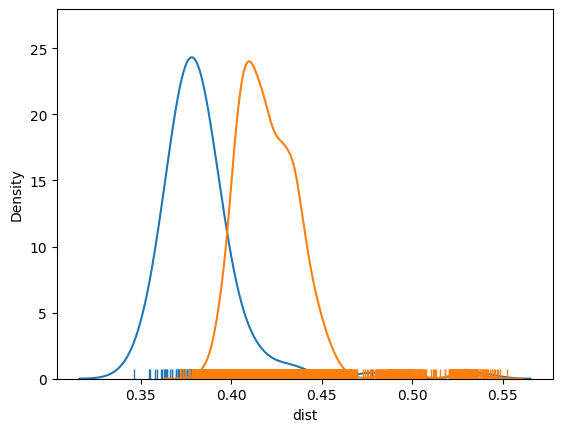

In [33]:
import seaborn as sns
sns.distplot(sameday_records_intra['dist'], hist=False, rug=True)
sns.distplot(sameday_records_inter['dist'], hist=False, rug=True)

Evaluate over all the dataset

/var/folders/dr/0sfvl25x4g52yq83p63vd7sm0000gn/T/ipykernel_78501/4294177613.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(all_fhd_dataset['dist'], hist=False, rug=True)
/var/folders/dr/0sfvl25x4g52yq83p63vd7sm0000gn/T/ipykernel_78501/4294177613.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad637275

<Axes: xlabel='dist', ylabel='Density'>

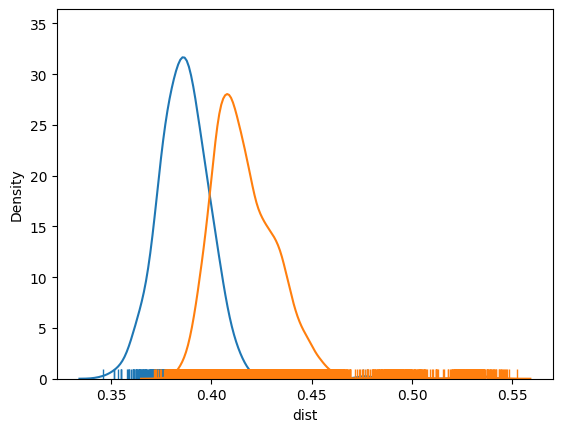

In [34]:
sns.distplot(all_fhd_dataset['dist'], hist=False, rug=True)
sns.distplot(all_fhd_dataset_full['dist'], hist=False, rug=True)

### Compute the uniqueness

/var/folders/dr/0sfvl25x4g52yq83p63vd7sm0000gn/T/ipykernel_78501/1222526818.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tot_uniq, hist=True, rug=True)


<Axes: ylabel='Density'>

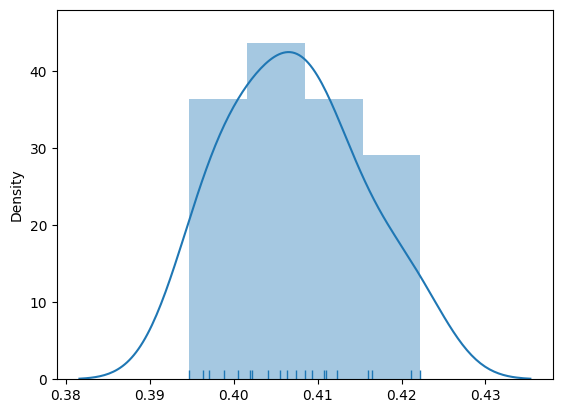

In [35]:
tot_uniq = list()
for y in dict_all_records['Person_01']:
    single_val = all_fhd_dataset_full[all_fhd_dataset_full['r1'].isin([y]) & all_fhd_dataset_full['r2'].isin([y])]
    tot_sum = np.sum(single_val['dist'])
    uniqueness = 1/len(single_val) * tot_sum 
    tot_uniq.append(uniqueness)
sns.distplot(tot_uniq, hist=True, rug=True)

### Compute the Stability

/var/folders/dr/0sfvl25x4g52yq83p63vd7sm0000gn/T/ipykernel_78501/2252105302.py:5: RuntimeWarning: invalid value encountered in scalar divide
  single_sum = np.sum(stab_ofperson['dist']) / len(stab_ofperson)
/var/folders/dr/0sfvl25x4g52yq83p63vd7sm0000gn/T/ipykernel_78501/2252105302.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tot_stab, hist=True, rug=True)


<Axes: ylabel='Density'>

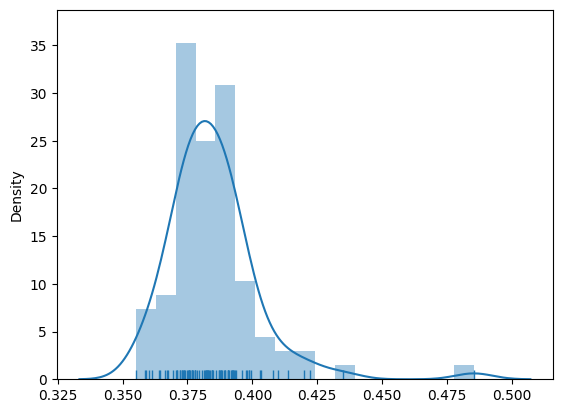

In [36]:
import math
tot_stab = list()
for person in dict_all_records:
    stab_ofperson = all_fhd_dataset[all_fhd_dataset['p'] == person]
    single_sum = np.sum(stab_ofperson['dist']) / len(stab_ofperson)
    if not math.isnan(single_sum):
        tot_stab.append(single_sum)
sns.distplot(tot_stab, hist=True, rug=True)

### Uniformity

/var/folders/dr/0sfvl25x4g52yq83p63vd7sm0000gn/T/ipykernel_78501/4011744065.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tot_unif, hist=True, rug=True)


<Axes: ylabel='Density'>

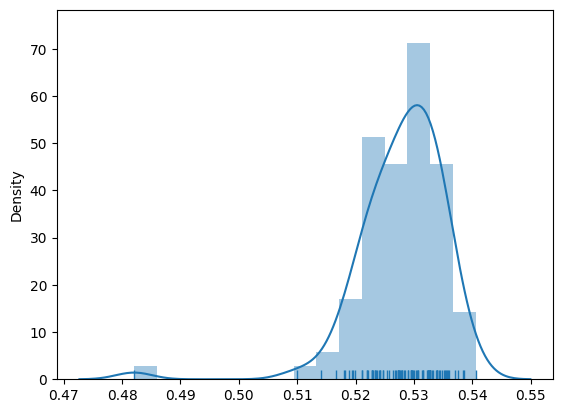

In [37]:
tot_unif = list()
for person in dict_all_records:
    current = dict_binaries[person]['rec_1']
    tot_ones = 0
    for x in current:
        if x == '1':
            tot_ones += 1
    tot_unif.append(tot_ones/len(current))
sns.distplot(tot_unif, hist=True, rug=True)

### Entropy

In [38]:
import math

tot_sum = 0

for x in range(len(dict_binaries['Person_01']['rec_1'])):
    total_p_logic_1 = 0

    for person, records in dict_binaries.items():
        p_1_current_person = sum(int(record[x]) for record in records.values())
        p_logic_1_current_person = p_1_current_person / len(records)
        total_p_logic_1 += p_logic_1_current_person

    p_logic_1 = total_p_logic_1 / len(dict_binaries)
    p_logic_0 = 1 - p_logic_1
    tot_sum += -math.log2(max(p_logic_1, p_logic_0))

print(tot_sum/len(dict_binaries['Person_01']['rec_1']))

0.7434478109453234
